In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time as time

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from tensorflow import keras
from keras import layers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Dataset

In [3]:
df = pd.read_csv("./dataset/train.csv")
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (500000, 36)


,label,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0,1.721656,-2.026168,-1.678496,-0.517512,-0.567964,1.054221,0.069819,1.048858,0.832034,...,1.634686,0.849622,0.315492,-0.338898,-0.412601,1.027683,-1.542995,1.960504,-0.567663,-1.140047
1,0,1.596194,-1.577304,-0.706441,-1.553644,-1.173163,1.054221,0.125655,1.365986,0.756011,...,0.253726,0.901653,-0.305200,-0.221213,-1.351918,0.885052,-1.312088,-0.032521,-0.925837,-0.683991
2,0,2.096867,-0.477000,0.598374,0.239101,-0.209981,-0.850488,0.889856,0.811048,0.357467,...,1.544468,0.391239,1.085081,0.862539,-1.456647,-1.323906,-1.494468,0.947688,-0.288821,-0.364749
3,0,1.019743,-1.411434,-0.872602,0.153695,0.631471,-2.755198,-0.760561,0.143261,-1.253862,...,1.258645,-0.587911,0.110567,0.567624,-1.512797,-0.707736,-2.172718,0.045091,-0.345398,0.045562
4,0,0.877437,-0.507518,-0.818602,0.280093,-0.375073,0.005984,0.342253,0.964911,0.599365,...,0.955726,2.191106,0.429383,-1.432677,-0.407917,0.362277,-2.856638,1.672222,-0.617077,1.829777


In [4]:
X, y = df.iloc[:, 1:].to_numpy(), df["label"].to_numpy()
print(f"X shape: {X.shape}, y shape: {y.shape}")

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) # random state can be modify
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True) # random state can be modify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")

X shape: (500000, 35), y shape: (500000,)
X_train shape: (450000, 35), y_train shape: (450000,)
X_valid shape: (50000, 35), y_valid shape: (50000,)


In [5]:
# # Handling Outliers
# # Calculate IQR
# # Q1 = X_train.quantile(0.25)
# # Q3 = X_train.quantile(0.75)
# # IQR = Q3 - Q1

# # # Defining bounds for outliers
# # lower_bound = Q1 - 1.5 * IQR
# # upper_bound = Q3 + 1.5 * IQR

# # # Replacing outliers with the upper and lower bounds
# # X_train = X_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
# # X_valid = X_valid.clip(lower=lower_bound, upper=upper_bound, axis=1)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(450000, 35) (450000,)
(50000, 35) (50000,)


### Data Visualize

Label 0: 405059, Label 1: 44941
Imbalance scale: 9.013128323802318


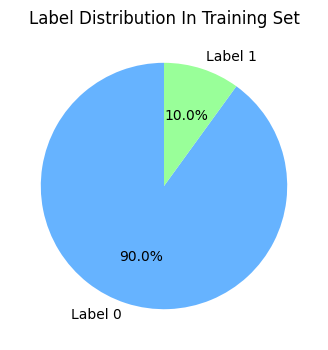

In [6]:
label_counts = np.bincount(y_train)
pos_sample = np.sum(y_train == 1)
neg_sample = np.sum(y_train == 0)
scale_weight = neg_sample / pos_sample
print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")
print(f"Imbalance scale: {scale_weight}")

plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution In Training Set')
plt.show()

Label 0: 44941, Label 1: 5059


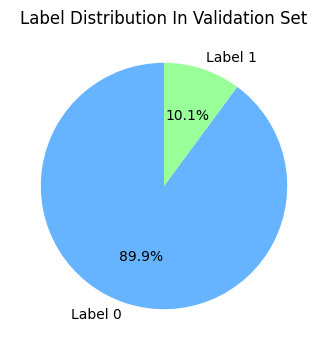

In [7]:
label_counts = np.bincount(y_valid)
pos_sample = np.sum(y_valid == 1)
neg_sample = np.sum(y_valid == 0)
print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")

plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution In Validation Set')
plt.show()

### Data preprocess

In [8]:
# # 卡方檢定
# scaler = MinMaxScaler()
# X_train_scale = scaler.fit_transform(X_train)
# X_valid_scale = scaler.transform(X_valid)

# k =10
# chi2_selector = SelectKBest(chi2, k=k)
# chi2_selector.fit(X_train_scale, y_train)

# selected_features = chi2_selector.get_support(indices=True)
# print(selected_features)
# X_train_selected = X_train_scale[:, selected_features]
# X_valid_selected = X_valid_scale[:, selected_features]
# print(X_train_selected.shape)

# # selected_feature_names.tolist()

In [35]:
# PCA
ratio = 0.5
n_components = int(X_train.shape[1] * ratio)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

X_train_pca.shape, X_valid_pca.shape

((450000, 17), (50000, 17))

In [36]:
# smote = SMOTE()
# smote_enn = SMOTEENN()
# smote_tomek = SMOTETomek()

# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# # X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_std, y_train)
# # X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)


# label_counts = np.bincount(y_train_resampled)
# pos_sample = np.sum(y_train_resampled == 1)
# neg_sample = np.sum(y_train_resampled == 0)
# print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")

# plt.figure(figsize=(4, 4))
# plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
# plt.title('Label Distribution In Resample Set')
# plt.show()

### Ensemble Model

In [11]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

### XGBoost

In [48]:
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=7, 
    early_stopping_rounds=50,
    objective='binary:logistic', 
    reg_lambda=1.2, 
    min_child_weight=4,
    eval_metric='auc',
    scale_pos_weight=1.5, # 1.5
    n_jobs=-1,)

eval_set = [(X_train, y_train), (X_valid, y_valid)]

xgb.fit(X_train, y_train, eval_set=eval_set, verbose=10)

y_pred_train = xgb.predict(X_train)
y_pred_val =  xgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 


[0]	validation_0-auc:0.94032	validation_1-auc:0.93959
[10]	validation_0-auc:0.95102	validation_1-auc:0.94889
[20]	validation_0-auc:0.95471	validation_1-auc:0.95060
[30]	validation_0-auc:0.95801	validation_1-auc:0.95116
[40]	validation_0-auc:0.96097	validation_1-auc:0.95122
[50]	validation_0-auc:0.96345	validation_1-auc:0.95093
[60]	validation_0-auc:0.96568	validation_1-auc:0.95073
[70]	validation_0-auc:0.96767	validation_1-auc:0.95036
[80]	validation_0-auc:0.96980	validation_1-auc:0.95037
[82]	validation_0-auc:0.97009	validation_1-auc:0.95027
F1-score on train: 0.82603674711178
F1-score on valid: 0.8134802842253803


[('Feature 20', 0.004463637), ('Feature 17', 0.004741613), ('Feature 7', 0.0050163004), ('Feature 23', 0.005054185), ('Feature 14', 0.0050601647), ('Feature 31', 0.005065553), ('Feature 15', 0.005071924), ('Feature 30', 0.005100128), ('Feature 34', 0.005194711), ('Feature 32', 0.005213316), ('Feature 0', 0.00524858), ('Feature 25', 0.0052731484), ('Feature 29', 0.005331063), ('Feature 16', 0.005350428), ('Feature 10', 0.0054499456), ('Feature 27', 0.0056998204), ('Feature 18', 0.00573444), ('Feature 4', 0.006001617), ('Feature 6', 0.0062703197), ('Feature 11', 0.00636662), ('Feature 22', 0.007035687), ('Feature 28', 0.007128702), ('Feature 8', 0.007779459), ('Feature 33', 0.007834676), ('Feature 13', 0.009238725), ('Feature 5', 0.011378911), ('Feature 21', 0.014574358), ('Feature 12', 0.024049586), ('Feature 3', 0.025981942), ('Feature 26', 0.029073188), ('Feature 9', 0.044241205), ('Feature 1', 0.06434101), ('Feature 24', 0.07408616), ('Feature 19', 0.19723737), ('Feature 2', 0.369311

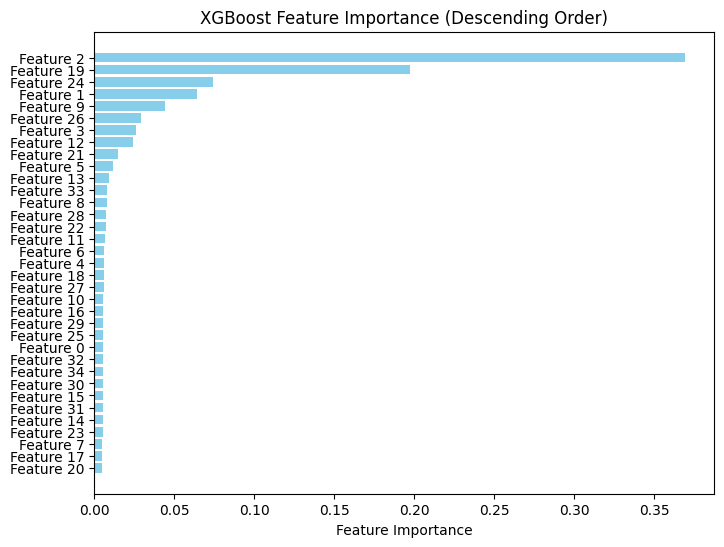

In [49]:
feature_importances = xgb.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

features_importance_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Descending Order)')
plt.show()

In [50]:
threshold = 0.01

X_train_selected = X_train[:, feature_importances > threshold]
X_valid_selected = X_valid[:, feature_importances > threshold]

print(X_train_selected.shape)
print(X_valid_selected.shape)

(450000, 10)
(50000, 10)


In [52]:
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=7, 
    early_stopping_rounds=50,
    objective='binary:logistic', 
    reg_lambda=1.2, 
    min_child_weight=4,
    # eval_metric='auc',
    scale_pos_weight=1.5, # 1.5
    n_jobs=-1,)

eval_set = [(X_train_selected, y_train), (X_valid_selected, y_valid)]

xgb.fit(X_train_selected, y_train, eval_set=eval_set, verbose=10)

y_pred_train = xgb.predict(X_train_selected)
y_pred_val =  xgb.predict(X_valid_selected)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

[0]	validation_0-logloss:0.27616	validation_1-logloss:0.27788
[10]	validation_0-logloss:0.16168	validation_1-logloss:0.16433
[20]	validation_0-logloss:0.15436	validation_1-logloss:0.15870
[30]	validation_0-logloss:0.15165	validation_1-logloss:0.15799
[40]	validation_0-logloss:0.14935	validation_1-logloss:0.15769
[50]	validation_0-logloss:0.14766	validation_1-logloss:0.15780
[60]	validation_0-logloss:0.14532	validation_1-logloss:0.15781
[70]	validation_0-logloss:0.14340	validation_1-logloss:0.15830
[80]	validation_0-logloss:0.14158	validation_1-logloss:0.15836
[90]	validation_0-logloss:0.14003	validation_1-logloss:0.15863
[91]	validation_0-logloss:0.13982	validation_1-logloss:0.15863
F1-score on train: 0.8219857259851999
F1-score on valid: 0.8120535603042581


### LGBM

In [53]:
lgb = LGBMClassifier(
  n_estimators=500, 
  max_depth=7, 
  num_leaves=101,
  min_child_samples=8,
  reg_lambda=1.2, 
  early_stopping_rounds=50,
  # is_unbalance=True,
  scale_pos_weight=2,
  n_jobs=-1,
  verbose=10)

lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

y_pred_train = lgb.predict(X_train)
y_pred_val =  lgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 44941, number of negative: 405059
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000013 seconds, init for row-wise cost 0.074380 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 8790
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 35
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099869 -> initscore=-2.198682
[Lig

[('Feature 20', 90), ('Feature 10', 98), ('Feature 5', 495), ('Feature 19', 1276), ('Feature 21', 1280), ('Feature 6', 1281), ('Feature 22', 1287), ('Feature 31', 1287), ('Feature 25', 1315), ('Feature 29', 1335), ('Feature 23', 1369), ('Feature 33', 1375), ('Feature 30', 1380), ('Feature 7', 1388), ('Feature 34', 1390), ('Feature 0', 1392), ('Feature 32', 1399), ('Feature 16', 1402), ('Feature 27', 1419), ('Feature 15', 1421), ('Feature 14', 1423), ('Feature 11', 1425), ('Feature 17', 1430), ('Feature 28', 1434), ('Feature 8', 1438), ('Feature 18', 1493), ('Feature 9', 1507), ('Feature 4', 1561), ('Feature 26', 1586), ('Feature 24', 1603), ('Feature 2', 1700), ('Feature 12', 1719), ('Feature 3', 1786), ('Feature 13', 1832), ('Feature 1', 2107)]


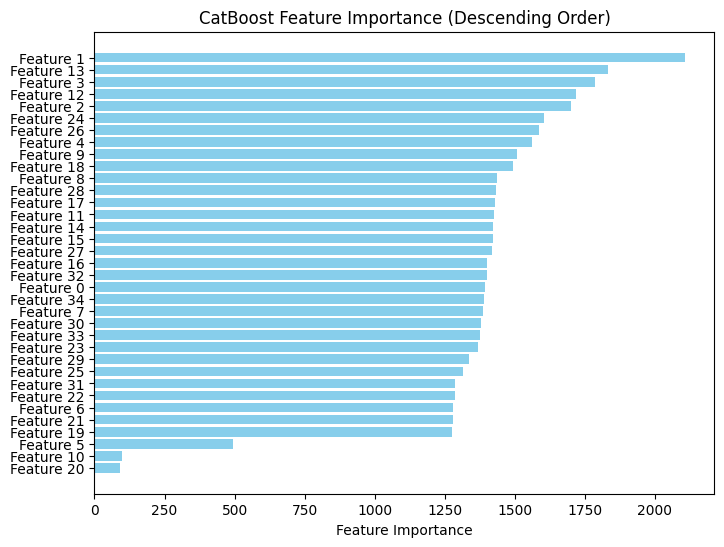

In [54]:
feature_importances = lgb.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

features_importance_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance (Descending Order)')
plt.show()

In [55]:
threshold = 1400

X_train_selected = X_train[:, feature_importances > threshold]
X_valid_selected = X_valid[:, feature_importances > threshold]

print(X_train_selected.shape)
print(X_valid_selected.shape)

(450000, 18)
(50000, 18)


In [56]:
lgb = LGBMClassifier(
  n_estimators=500, 
  max_depth=7, 
  num_leaves=101,
  min_child_samples=8,
  reg_lambda=1.2, 
  early_stopping_rounds=50,
  # is_unbalance=True,
  scale_pos_weight=2,
  n_jobs=-1,
  verbose=10)

lgb.fit(X_train_selected, y_train, eval_set=(X_valid_selected, y_valid))

y_pred_train = lgb.predict(X_train_selected)
y_pred_val =  lgb.predict(X_valid_selected)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 44941, number of negative: 405059
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.022012 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 18
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099869 -> initscore=-2.198682
[LightGBM] [Info] Start training from score -2.198682
[LightGBM] [Warning] No further splits with positive gain, 

### Cat Boost

In [100]:
cat = CatBoostClassifier(
    # depth=8,
    iterations=2000,
    class_weights=[1, 9],
    # early_stopping_rounds=100,
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=10)

y_pred_train = cat.predict(X_train)
y_pred_val =  cat.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.031796
0:	learn: 0.8321673	test: 0.8349435	best: 0.8349435 (0)	total: 13.6ms	remaining: 27.2s
10:	learn: 0.8463130	test: 0.8495246	best: 0.8509048 (9)	total: 126ms	remaining: 22.7s
20:	learn: 0.8524244	test: 0.8573008	best: 0.8573008 (20)	total: 242ms	remaining: 22.8s
30:	learn: 0.8565709	test: 0.8602093	best: 0.8602093 (30)	total: 351ms	remaining: 22.3s
40:	learn: 0.8601817	test: 0.8639907	best: 0.8641049 (37)	total: 461ms	remaining: 22s
50:	learn: 0.8626173	test: 0.8677177	best: 0.8677177 (50)	total: 593ms	remaining: 22.7s
60:	learn: 0.8646141	test: 0.8698977	best: 0.8700802 (59)	total: 714ms	remaining: 22.7s
70:	learn: 0.8664537	test: 0.8713690	best: 0.8713690 (70)	total: 826ms	remaining: 22.5s
80:	learn: 0.8677583	test: 0.8721482	best: 0.8721482 (80)	total: 941ms	remaining: 22.3s
90:	learn: 0.8687361	test: 0.8731913	best: 0.8731913 (90)	total: 1.06s	remaining: 22.3s
100:	learn: 0.8692981	test: 0.8743048	best: 0.8743048 (100)	total: 1.18s	remaining: 22.3s
110:

[('Feature 20', 0.036669819458986945), ('Feature 10', 0.07479082768205254), ('Feature 7', 0.30223047883449566), ('Feature 29', 0.30471055919496237), ('Feature 23', 0.3280829070902584), ('Feature 17', 0.33331239062970813), ('Feature 31', 0.34638209427013683), ('Feature 25', 0.35112141919508855), ('Feature 15', 0.4056724652684049), ('Feature 14', 0.4065456209872909), ('Feature 34', 0.42088023852754586), ('Feature 32', 0.46926662405312985), ('Feature 0', 0.49040428419095683), ('Feature 30', 0.5632017917782537), ('Feature 16', 0.5921905299802964), ('Feature 18', 0.6491380754982139), ('Feature 22', 0.6878320537120087), ('Feature 8', 0.9219719697685962), ('Feature 27', 0.9457549156621122), ('Feature 11', 1.0047230159361016), ('Feature 6', 1.0502616273445968), ('Feature 28', 1.0832071938401364), ('Feature 21', 1.3921964162243554), ('Feature 5', 1.6189112576414124), ('Feature 4', 1.7111097912282167), ('Feature 24', 1.9200513932732373), ('Feature 26', 2.0497759392906123), ('Feature 33', 2.12914

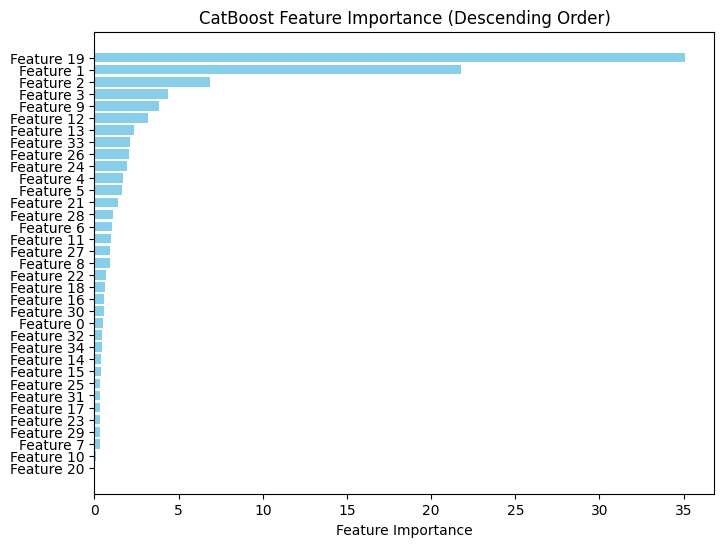

In [69]:
feature_importances = cat.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

features_importance_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance (Descending Order)')
plt.show()

In [70]:
threshold = 1

X_train_selected = X_train[:, feature_importances > threshold]
X_valid_selected = X_valid[:, feature_importances > threshold]

print(X_train_selected.shape)
print(X_valid_selected.shape)

(450000, 16)
(50000, 16)


In [72]:
cat = CatBoostClassifier(
    iterations=2000,
    class_weights=[1, 1.2],
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

cat.fit(X_train_selected, y_train, eval_set=(X_valid_selected, y_valid), verbose=10)

y_pred_train = cat.predict(X_train_selected)
y_pred_val =  cat.predict(X_valid_selected)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.031796
0:	learn: 0.5976052	test: 0.5919042	best: 0.5919042 (0)	total: 11ms	remaining: 22s
10:	learn: 0.6164644	test: 0.6100594	best: 0.6100594 (10)	total: 111ms	remaining: 20s
20:	learn: 0.6090705	test: 0.6016734	best: 0.6101367 (12)	total: 232ms	remaining: 21.9s
30:	learn: 0.6087332	test: 0.6047502	best: 0.6101367 (12)	total: 339ms	remaining: 21.5s
40:	learn: 0.6143613	test: 0.6073888	best: 0.6101367 (12)	total: 447ms	remaining: 21.3s
50:	learn: 0.6196115	test: 0.6131602	best: 0.6131602 (50)	total: 547ms	remaining: 20.9s
60:	learn: 0.6246720	test: 0.6223533	best: 0.6223533 (60)	total: 650ms	remaining: 20.7s
70:	learn: 0.6301628	test: 0.6291954	best: 0.6291954 (70)	total: 759ms	remaining: 20.6s
80:	learn: 0.6333684	test: 0.6325648	best: 0.6325648 (80)	total: 858ms	remaining: 20.3s
90:	learn: 0.6359045	test: 0.6336871	best: 0.6336871 (90)	total: 955ms	remaining: 20s
100:	learn: 0.6381476	test: 0.6377158	best: 0.6377158 (100)	total: 1.05s	remaining: 19.8s
110:	lear

### Voting

In [40]:
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=5, 
    # early_stopping_rounds=50,
    objective='binary:logistic', 
    reg_lambda=1.2, 
    min_child_weight=4,
    # eval_metric='auc',
    scale_pos_weight=2, # 1.5
    n_jobs=-1)

lgb = LGBMClassifier(
  n_estimators=500, 
  max_depth=7, 
  num_leaves=101,
  min_child_samples=8,
  reg_lambda=1.2, 
  # early_stopping_rounds=20,
  # is_unbalance=True,
  scale_pos_weight=1.5,
  n_jobs=-1,
  verbose=10)
cat = CatBoostClassifier(
    # depth=8,
    iterations=2000,
    class_weights=[1, 2],
    # early_stopping_rounds=100,
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

voting = VotingClassifier(estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat)], voting='soft', n_jobs=-1, verbose=True)

voting.fit(X_train, y_train)

y_pred_train = voting.predict(X_train)
y_pred_val =  voting.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.8697458394760171
F1-score on valid: 0.8163827415183884


### Evaluation

In [76]:
# y_pred_train = cat.predict(X_train_selected)
# y_pred_val =  cat.predict(X_valid_selected)
# # y_pred_train = xgb.predict(X_train)
# # y_pred_val =  xgb.predict(X_valid)
# # y_pred_train = lgb.predict(X_train)
# # y_pred_val =  lgb.predict(X_valid)

# # y_pred_prob_train = cat.predict_proba(X_train)[:, 1]
# # y_pred_prob_val = cat.predict_proba(X_valid)[:, 1]

# # threshold = 0.5
# # y_pred_train = (y_pred_prob_train > threshold).astype(int)
# # y_pred_val = (y_pred_prob_val > threshold).astype(int)

# print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
# print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.8420441290909451
F1-score on valid: 0.822430549017847


### Submmit

In [64]:
df_test = pd.read_csv('./dataset/test.csv')

Id = df_test['id'].to_numpy()
X_test = df_test.iloc[:, 1:].to_numpy()
# X_test_std = sc.transform(X_test)
# X_test_selected = X_test_std[:, feature_importances > threshold]
print(f"X_test shape: {X_test.shape}")

X_test shape: (200000, 35)


In [65]:
X_test_scale = sc.transform(X_test)

print(X_test_scale.shape)

(200000, 35)


In [98]:
y_pred_test = cat.predict(X_test_scale)
# y_pred_test = voting.predict(X_test_scale)

In [99]:
output_data = {'id': Id, 'label': y_pred_test}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)
print(output_dataframe['label'].value_counts())

output_dataframe.to_csv("./dataset/y_pred.csv", index=None)

            id  label
0            0      0
1            1      1
2            2      1
3            3      0
4            4      0
...        ...    ...
199995  199995      1
199996  199996      0
199997  199997      1
199998  199998      1
199999  199999      0

[200000 rows x 2 columns]
label
1    123809
0     76191
Name: count, dtype: int64
